# PDF Document Loading and Starting RAG
Use pdf loading library to feed pdfs into llm. Tutorial uses PyMuPdf. It is **already available within langchain_community.**

PyMuPdf vs. Pypdf: pymu is faster at just extracting text from pdfs; sometimes it handles graphics and formatting better too. However, potentially less secure and has reliability issues. pypdf is slower but may be considered more stable and ready for enterprise use. Often has issues with formatting. 

Other loaders + langchain docs: https://python.langchain.com/docs/integrations/document_loaders/

We will also use *tiktoken*, which helps tokenize the text. It is included in the openai library installation in requirements.txt.

In [34]:
from langchain_community.document_loaders import PyMuPDFLoader
from dotenv import load_dotenv
load_dotenv('.env')
import os, glob, tiktoken
os.environ['LANGCHAIN_ENDPOINT']

'https://api.smith.langchain.com'

using finance pdfs for this exercise from: https://github.com/pistolla/gnidart/tree/master
tutorial uses health supplement pdfs instead

In [7]:
loader = PyMuPDFLoader("finance_pdfs/Market Wizards - Interviews With Top Traders 2012.pdf")
docs = loader.load()
len(docs) # number of pages

215

In [9]:
docs[0].metadata

{'producer': 'Acrobat Distiller 7.0 (Windows)',
 'creator': 'Acrobat PDFMaker 7.0 for Word',
 'creationdate': '2005-03-29T21:52:01+02:00',
 'source': 'finance_pdfs/Market Wizards - Interviews With Top Traders 2012.pdf',
 'file_path': 'finance_pdfs/Market Wizards - Interviews With Top Traders 2012.pdf',
 'total_pages': 215,
 'format': 'PDF 1.3',
 'title': 'THE MARKET WIZARDS',
 'author': 'AnToni',
 'subject': '',
 'keywords': '',
 'moddate': '2013-09-13T01:07:18+01:00',
 'trapped': '',
 'modDate': "D:20130913010718+01'00'",
 'creationDate': "D:20050329215201+02'00'",
 'page': 0}

In [18]:
print(docs[0].page_content)

THE MARKET WIZARDS 
 
CONVERSATIONS WITH 
AMERICA'S TOP TRADERS 
JACK  D. SCHWAGER


-- read all pdfs, tutorial goes through this way - debatably more convoluted for no reason\
pdfs = []
for root, dir, files in os.walk("finance_pdfs"):
    for file in files:
        if file.endswith('.pdf'):
            pdfs.append(os.path.join(root, file))

In [2]:
# load all pdfs
files = glob.glob('finance_pdfs/*.pdf')

docs = []
for file in files:
    loader = PyMuPDFLoader(file)
    temp = loader.load()
    docs.extend(temp) # loads all pages into array of docs (across all pdfs)

len(docs)

1225

In [12]:
# function to format text into a single string; each page separated by 2 newlines
def format_text(files):
    docs = []
    for file in files:
        loader = PyMuPDFLoader(file)
        temp = loader.load()
        docs.extend(temp) # loads all pages into array of docs (across all pdfs)
        
    return "\n\n".join([x.page_content for x in docs]), docs

In [ ]:
files = glob.glob('finance_pdfs/*.pdf')
context, docs = format_text(files)

In [5]:
print(context[:1000])

THE MARKET WIZARDS 
 
CONVERSATIONS WITH 
AMERICA'S TOP TRADERS 
JACK  D. SCHWAGER

2
HarperBusiness 
 
 
 
You've got to learn how to fall, before you learn to fly. 
—Paul Simon 
 
One man's ceiling is another man's floor. 
—Paul Simon 
 
If I wanted to become a tramp, I would seek information and advice from the most successful tramp 
I could find. If I wanted to become a failure, I would seek advice from men who had never 
succeeded. If I wanted to succeed in all things, I would look around me for those who are 
succeeding and do as they have done. 
—Joseph Marshall Wade 
(as quoted in a Treasury of Wall Street Wisdom 
edited by Harry D. Schultz and Samson Coslow)

3
Contents 
 
Preface...................................................................................................................................................4 
Acknowledgments ................................................................................................................................5 
Prolo

# Chunking and intro to RAG
LLMs will not have a big enough context window to handle something of this size. 

In [6]:
# reimporting and organizing code
from langchain_community.document_loaders import PyMuPDFLoader
from dotenv import load_dotenv
load_dotenv('.env')
import os, glob, tiktoken

In [13]:
files = glob.glob('finance_pdfs/*.pdf')
context, docs = format_text(files) # get context from all pdfs

Getting encoding using tiktoken. Currently only supports OpenAI models, but will be used for this example.

In [8]:
encoding = tiktoken.encoding_for_model("gpt-4o-mini") # only support openai models, may update in the future

In [10]:
encoding.encode("congratulations"), encoding.encode('hello') # example of encoding output

([542, 111291, 14571], [24912])

In [16]:
# number of tokens from first two page of docs
print(len(encoding.encode(docs[0].page_content)), len(encoding.encode(docs[1].page_content)))

# number of tokens from all pages
print(len(encoding.encode(context)))

27 140
761192


### NOTE:
The current used LLM is Llama3.2, which has a 128k token length. This means that if unless we split up the documents, it will exceed the context window. This wouldn't be an issue with smaller text, but it is unreasonable to assume a small text base. Before going fully into RAG, we will try to use a smaller text base to do summarization and question answering via LLM.
### 1. LLM-powered text parser - Q&A chat

In [20]:
files = glob.glob('finance_pdfs/The Disciplined Trader - Developing Winning Attitudes 1990.pdf')
context, docs = format_text(files) # single pdf for context window size
encoding.encode(context)
len(encoding.encode(context))

99663

In [17]:
# bringing in the llm
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser
base_url = 'http://localhost:11434'
llm = ChatOllama(base_url=base_url, model='llama3.2')

In [38]:
system = SystemMessagePromptTemplate.from_template("You are a financial analyst. You will be given a question and a context. " \
"Answer the question using the context. If the answer is not in the context, say 'I don't know'. Do not answer in more than {words} words.")

prompt = """Answer user questino based on the provided context ONLY. If you do not know the answer, just say "I don't know".
            ### Context:
            {context}

            ### Question:
            {question}

            ### Answer:
"""

prompt = HumanMessagePromptTemplate.from_template(prompt)

messages = [system, prompt]
template = ChatPromptTemplate(messages=messages)

#template.invoke({'context': context, 'question': 'What are the three stages to becoming a successful trader?', 'words': 100})
qna_chain = template | llm | StrOutputParser()

In [27]:
response = qna_chain.invoke({'context': context, 'question': 'What are the three stages to becoming a successful trader?', 'words': 50})
print(response)

The text does not explicitly state the three stages to becoming a successful trader. However, based on the context and content of the book, it can be inferred that the three stages are:

1. **Developing Objectivity**: This involves learning to monitor your thoughts, feelings, and market information, and developing uncommitted assessments of probabilities. It also means recognizing when you're distorting or avoiding certain information and taking steps to improve your objective thinking.
2. **Staying Objective in Trading**: This stage involves being aware of how you feel about your trades, whether anything "has to happen," and questioning what can't happen. It also requires monitoring your level of commitment to specific outcomes and taking actions to manage risk and uncertainty.
3. **Embracing Self-Validation**: The final stage involves recognizing that self-worth and value are not tied to external factors like money or success, but rather to one's own self-perception and well-being. T

Example of question not related to text:

In [28]:
missing_data_response = qna_chain.invoke({'context': context, 'question': 'What is a kiwi?', 'words': 50})
print(missing_data_response)

There is no answer to this question. The text provided appears to be an excerpt from a book about trading, but it does not mention "kiwi" at all. It seems that the prompt was incomplete or misdirected. If you would like to provide more context or clarify what you are looking for, I'll do my best to assist you.


### 2. Report Generation from PDF Document (detailed summary)
Using the Q&A template, we can ask it to generate a report of the context provided. It can make a very detailed summary/report of the text given, and you can structure it or prompt it however you want.

In [39]:
response = qna_chain.invoke({'context': context, 
                             'question': 'Provide a detailed report from the provided context. Write the answer in Markdown.', 
                             'words': 2000})
print(response)

**Detailed Report: Understanding Objectivity in Trading**

The provided context discusses the importance of objectivity in trading, highlighting the need for traders to move beyond their personal biases and emotions when making trading decisions.

**Key Takeaways:**

1. **Objectivity vs. Commitment**: The chapter emphasizes the distinction between "what is happening" (e.g., market movements) and "something that has to happen." Traders should focus on observing the market's behavior rather than imposing their own expectations.
2. **Monitoring Yourself**: The exercise for self-discipline encourages traders to pay attention to their thoughts, feelings, and market information. By monitoring themselves, traders can identify potential biases and adjust their approach accordingly.
3. **Reducing Distortion**: Traders should be aware of situations that may lead to distortion (e.g., focusing on monetary value instead of market structure). Taking a step back and reassessing their approach can hel

### 3. Text summarization (basic summary)

In [31]:
system = SystemMessagePromptTemplate.from_template("""You are a helpful AI assistant who works as a document summarizer. 
                                                   You must not hallucinate or provide any false information. Only respond with information you are sure about.
                                                   """)

prompt = """Summarize the given context in {words} words.
            ### Context:
            {context}

            ### Summary:
"""

prompt = HumanMessagePromptTemplate.from_template(prompt)

messages = [system, prompt]
template = ChatPromptTemplate(messages=messages)

summary_chain = template | llm | StrOutputParser()
summary_chain

ChatPromptTemplate(input_variables=['context', 'words'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful AI assistant who works as a document summarizer. \n                                                   You must not hallucinate or provide any false information. Only respond with information you are sure about.\n                                                   '), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'words'], input_types={}, partial_variables={}, template='Summarize the given context in {words} words.\n            ### Context:\n            {context}\n\n            ### Summary:\n'), additional_kwargs={})])
| ChatOllama(model='llama3.2', base_url='http://localhost:11434')
| StrOutputParser()

In [35]:
response = summary_chain.invoke({'context': context, 'words': 50}) 
print(response)

The text outlines seven steps to achieve objectivity in trading:

1. **Achieve Objectivity**: Feel no pressure to do anything, no fear, no sense of rejection, and no right or wrong. Recognize that this is what the market is telling you, not what you think it should be.
2. **Anticipate Possibilities**: Anticipate as many possibilities as you can and how probable each one is. Decide in advance what you will do in each situation.
3. **Monitor Yourself**: Pay attention to your thoughts and focus on the structure of the market, not its monetary value.
4. **Avoid Rationalizing**: Recognize when you are rationalizing the market's behavior to support your position, and take action to stop it.
5. **Be Prepared to Give Up**: If you're not prepared to give yourself money today, don't trade.
6. **Focus on Value, Not Money**: Focus on what the trade is worth to you in terms of dollars, dreams, goals, etc., rather than its monetary value.
7. **Self-Validation**: The only thing holding you back from 

# RAG Project
## 1. Vector storage
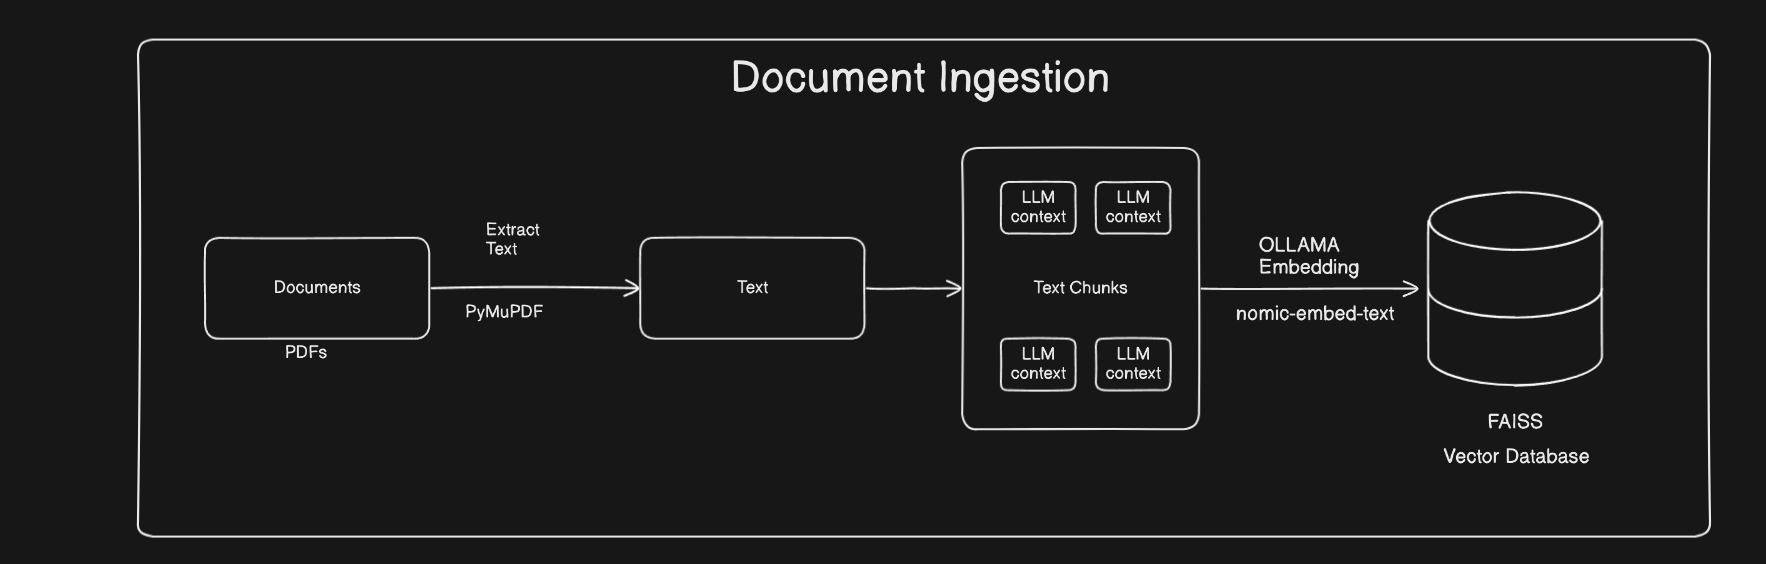
Text will be ingested and stored as vector database in FAISS (Facebook AI Similarity Search). There are alternative vector stores (i.e. Chroma), see documentation: https://python.langchain.com/docs/integrations/vectorstores/

In [54]:
import os, glob, tiktoken, warnings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
load_dotenv('.env')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # suppresses warnings for duplicate libraries; in case FAISS and other library has conflicts
warnings.filterwarnings('ignore')

encoding = tiktoken.encoding_for_model("gpt-4o-mini")

In [42]:
# Document loader
def format_text(files):
    docs = []
    for file in files:
        loader = PyMuPDFLoader(file)
        temp = loader.load()
        docs.extend(temp) # loads all pages into array of docs (across all pdfs)
        
    return "\n\n".join([x.page_content for x in docs]), docs

files = glob.glob('finance_pdfs/*.pdf')
context, docs = format_text(files) # get context from all pdfs

### Document Chunking
Focus the information into smaller context chunks. This allows for better retrieval results. For example, lots of variance in information; topic can change quickly from paragraph to paragraph -> smaller chunk size -- topic is discussed at length, across paragraphs or even pages (i.e. chapter by chapter of a book) -> larger chunk size.

In [56]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100) # split text into chunks of 1000 characters with 100 overlap
chunks = text_splitter.split_documents(docs) # split documents into chunks; should be a list of Document objects
print("Doc pages: " + str(len(docs)) + '\n' + 'Chunks: ' + str(len(chunks)))
print("Doc page 5 tokens: " + str(len(encoding.encode(docs[4].page_content))) + '\n' + 'Chunk 5 tokens: ' + str(len(encoding.encode(chunks[4].page_content))))

Doc pages: 1225
Chunks: 4042
Doc page 5 tokens: 450
Chunk 5 tokens: 88


### Document Vector Embedding
Convert text to embeddings and store in vector database. Will use this model: https://ollama.com/library/nomic-embed-text to create vector embeddings. **NOTE**: When building the retrieval side, make sure the SAME embedding process is used. If nomic-embed-text is used to embed, the same needs to be used to retrieve text values.

Vector store FAISS docs: https://python.langchain.com/docs/integrations/vectorstores/faiss/

In [62]:
# Embedding imports
from langchain_ollama import OllamaEmbeddings
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [63]:
# Bring in embedding model - LLM that generates embeddings
base_url = 'http://localhost:11434'
embeddings = OllamaEmbeddings(base_url=base_url, model='nomic-embed-text')

Suggestions from copilot:
--Optimize embedding settings
embeddings = OllamaEmbeddings(
    base_url='http://localhost:11434',
    model='nomic-embed-text',
    batch_size=32,  # Process more chunks per API call
    show_progress=True  # Add progress indicator
)

--Increase chunk size to reduce total chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # Larger chunks = fewer embeddings needed
    chunk_overlap=200
)

Code from tutorial

--initialize vector store
index = faiss.IndexFlatL2(len(embeddings.embed_query("Initialize vector store")))

--Create vector store (using FAISS in this example)
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(), # embeddings will be stored in RAM
    index_to_docstore_id={} # ids will be generated and stored here
)

vector_store.index.ntotal # number of vectors in the index
vector_store.index.d # dimension of the vectors in the index

In [68]:
# Create vector store from documents with custom settings matching tutorial
vector_store = FAISS.from_documents(
    documents=chunks,
    embedding=embeddings,
    docstore=InMemoryDocstore(),  # custom docstore
    index_to_docstore_id={}  # custom id mapping
)

In [71]:
vector_store.index.ntotal # all chunks have been added to vector store

4042

### Store vector store in machine
The current vector store is saved in RAM, and it will be lost after closing the project. We will store it in a db so that we don't need to re-process the vector embeddings.

In [75]:
vector_store.save_local('finance_books_vectorstore') # save vector store to local directory

## 2. Retrieval
Now that the vector embeddings have been stored to database, we will see how we can retrieve the information. REMEMBER TO USE THE SAME TOOL AS WHAT WAS USED FOR EMBEDDING. (nomic-embed-text)
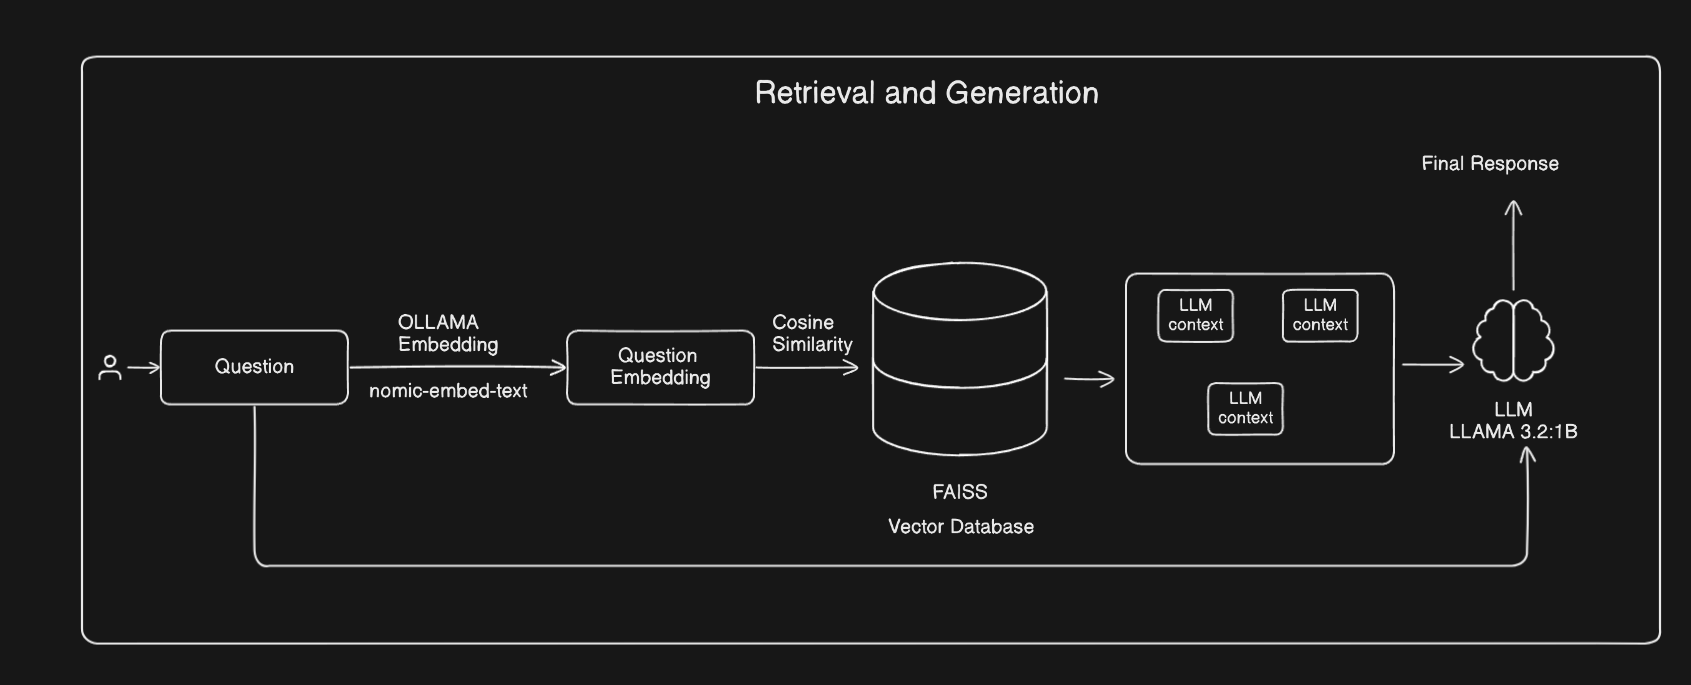

In [76]:
# retrieve from vector store
db_path = 'finance_books_vectorstore'
vector_store = FAISS.load_local(db_path, embeddings, allow_dangerous_deserialization=True) # load vector store from local directory

In [78]:
# successfully loaded vector store
question = "How can I get started with investing?"
docs = vector_store.search(query=question, k=5, search_type='similarity')
docs[0]

Document(id='cf9d3ac1-3e65-4814-97b7-f6facd08957f', metadata={'producer': 'Acrobat Distiller 5.0 (Windows)', 'creator': 'QuarkXPress.: AdobePS 8.7.3 (301)', 'creationdate': '2005-08-01T23:34:28+08:00', 'source': 'finance_pdfs\\The Intelligent Investor - A Book of Practical Counsel 2003.pdf', 'file_path': 'finance_pdfs\\The Intelligent Investor - A Book of Practical Counsel 2003.pdf', 'total_pages': 643, 'format': 'PDF 1.6', 'title': 'The Intelligent Investor', 'author': 'Benjamin Graham, Jason Zweig and Warren E. Buffett', 'subject': '', 'keywords': '', 'moddate': '2008-01-05T15:44:22+00:00', 'trapped': '', 'modDate': 'D:20080105154422Z', 'creationDate': "D:20050801233428+08'00'", 'page': 410}, page_content='amateurs can do better. The vast majority of people who try to pick\nstocks learn that they are not as good at it as they thought; the lucki-\nest ones discover this early on, while the less fortunate take years to\nlearn it. A small percentage of investors can excel at picking the

### Quick overview of search types
- Similarity: uses cosine similarity, where max value is 1 (matching text).
- MMR: smaller lambda increases diversity of returned documents. Larger lambda only focuses on most similar document.

In [90]:
# similarity search
retriever = vector_store.as_retriever(search_type='similarity', 
                                      search_kwargs={'k': 1}
                                      )
retriever.invoke(question)

[Document(id='cf9d3ac1-3e65-4814-97b7-f6facd08957f', metadata={'producer': 'Acrobat Distiller 5.0 (Windows)', 'creator': 'QuarkXPress.: AdobePS 8.7.3 (301)', 'creationdate': '2005-08-01T23:34:28+08:00', 'source': 'finance_pdfs\\The Intelligent Investor - A Book of Practical Counsel 2003.pdf', 'file_path': 'finance_pdfs\\The Intelligent Investor - A Book of Practical Counsel 2003.pdf', 'total_pages': 643, 'format': 'PDF 1.6', 'title': 'The Intelligent Investor', 'author': 'Benjamin Graham, Jason Zweig and Warren E. Buffett', 'subject': '', 'keywords': '', 'moddate': '2008-01-05T15:44:22+00:00', 'trapped': '', 'modDate': 'D:20080105154422Z', 'creationDate': "D:20050801233428+08'00'", 'page': 410}, page_content='amateurs can do better. The vast majority of people who try to pick\nstocks learn that they are not as good at it as they thought; the lucki-\nest ones discover this early on, while the less fortunate take years to\nlearn it. A small percentage of investors can excel at picking th

In [ ]:
# mmr search
retriever = vector_store.as_retriever(search_type='mmr', 
                                      search_kwargs={'k': 1, 'fetch_k': 20, 'lambda_mult': 1}
                                      )
retriever.invoke(question)

[Document(id='cf9d3ac1-3e65-4814-97b7-f6facd08957f', metadata={'producer': 'Acrobat Distiller 5.0 (Windows)', 'creator': 'QuarkXPress.: AdobePS 8.7.3 (301)', 'creationdate': '2005-08-01T23:34:28+08:00', 'source': 'finance_pdfs\\The Intelligent Investor - A Book of Practical Counsel 2003.pdf', 'file_path': 'finance_pdfs\\The Intelligent Investor - A Book of Practical Counsel 2003.pdf', 'total_pages': 643, 'format': 'PDF 1.6', 'title': 'The Intelligent Investor', 'author': 'Benjamin Graham, Jason Zweig and Warren E. Buffett', 'subject': '', 'keywords': '', 'moddate': '2008-01-05T15:44:22+00:00', 'trapped': '', 'modDate': 'D:20080105154422Z', 'creationDate': "D:20050801233428+08'00'", 'page': 410}, page_content='amateurs can do better. The vast majority of people who try to pick\nstocks learn that they are not as good at it as they thought; the lucki-\nest ones discover this early on, while the less fortunate take years to\nlearn it. A small percentage of investors can excel at picking th

## Integrating with Langchain
Connect retriever to LLM chain to perform retrieval using user's plain-text query. \
Langchain hub resource for prompts: https://smith.langchain.com/hub/search?q=RAG&organizationId=9d97b07a-8dc5-4857-9831-2b8f91625e17

In [83]:
# Retrieval imports
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain import hub # can use other peoples' prompts; can fork from prompts like https://smith.langchain.com/hub/daethyra/rag-prompt?organizationId=9d97b07a-8dc5-4857-9831-2b8f91625e17

In [94]:
prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in bullet points, and keep your answer concise. Make sure your answer is relevant to the question and it is answered from the context only.
Question: {question} 
Context: {context} 
Answer:
"""
prompt = ChatPromptTemplate.from_template(prompt)
messages = [prompt]

In [86]:
# grab llm again
llm = ChatOllama(base_url='http://localhost:11434', model='llama3.2')

In [87]:
# format docs into string 
def format_docs(docs):
    return "\n\n".join([x.page_content for x in docs]) # format into string; each page separated by 2 newlines'

In [88]:
context = format_docs(docs)
print(context[:1000]) 

amateurs can do better. The vast majority of people who try to pick
stocks learn that they are not as good at it as they thought; the lucki-
est ones discover this early on, while the less fortunate take years to
learn it. A small percentage of investors can excel at picking their own
stocks. Everyone else would be better off getting help, ideally through
an index fund.
Graham advised investors to practice first, just as even the greatest
athletes and musicians practice and rehearse before every actual per-
formance. He suggested starting off by spending a year tracking and
picking stocks (but not with real money).1 In Graham’s day, you would
396
1 Patricia Dreyfus, “Investment Analysis in Two Easy Lessons” (interview
with Graham), Money, July, 1976, p. 36.

147
Given the general scenario you are talking about—the stock market going down, the dollar 
going down, etc.—is there anything that the average guy can do to protect himself? 
Buy European and Far Eastern currencies; buy Treasury

In [95]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [96]:
question = "How can I get started with investing?"
response = rag_chain.invoke(question)
print(response)

Here are the key points to get started with investing from the context:

• Practice first: Spend a year tracking and picking stocks without real money.
• Get help: Consider using an index fund instead of trying to pick individual stocks yourself.
• Don't expect success: Many people who try to pick stocks struggle and may not excel at it.


In [99]:
question = "What do you think are the 5 most important things to remember while investing?"
response = rag_chain.invoke(question)
print(response)

Here are the 5 most important things to remember while investing based on the provided context:

• Investing consistently and dollar-cost averaging can help you own a diverse range of investments.
• It's essential to consider different sectors of the market and specific stocks or bonds within them for optimal performance.
• A diversified portfolio can ensure that you're invested in almost every worthwhile investment opportunity.
• The specific allocation of funds to each sector or investment is crucial for achieving your goals.
• A portion of your portfolio should be allocated to foreign stocks, as seen on pages 186-187.
